In [2]:
from utils import *
from envs import *
from model import *
import numpy as np
from copy import deepcopy
import argparse
import pandas as pd
import ast
parser = argparse.ArgumentParser()
parser.add_argument('--episodes', type=int, required=False, help='episodes', default=1)
parser.add_argument('--tmax', type=int, required=False, help='tmax', default=100)

parser.add_argument('--goalcoords', type=float,nargs='+', required=False, help='goalcoords', default=[0.5])
parser.add_argument('--rsz', type=float, required=False, help='rsz', default=0.05)
parser.add_argument('--rmax', type=int, required=False, help='rmax', default=5)

parser.add_argument('--seed', type=int, required=False, help='seed', default=2020)
parser.add_argument('--pcinit', type=str, required=False, help='pcinit', default='uni')
parser.add_argument('--npc', type=int, required=False, help='npc', default=32)
parser.add_argument('--alpha', type=float, required=False, help='alpha', default=1.0)
parser.add_argument('--sigma', type=float, required=False, help='sigma', default=0.05)

parser.add_argument('--plr', type=float, required=False, help='plr', default=0.01)
parser.add_argument('--clr', type=float, required=False, help='clr', default=0.01)
parser.add_argument('--llr', type=float, required=False, help='llr', default=0.000) 
parser.add_argument('--alr', type=float, required=False, help='alr', default=0.000) 
parser.add_argument('--slr', type=float, required=False, help='slr', default=0.000)
parser.add_argument('--gamma', type=float, required=False, help='gamma', default=0.9)
parser.add_argument('--nact', type=int, required=False, help='nact', default=2)

parser.add_argument('--balpha', type=float, required=False, help='balpha', default=0.0)
parser.add_argument('--paramsindex', type=int,nargs='+', required=False, help='paramsindex', default=[0,1,2])
parser.add_argument('--noise', type=float, required=False, help='noise', default=0.000)

parser.add_argument('--datadir', type=str, required=False, help='datadir', default='./data/')
parser.add_argument('--figdir', type=str, required=False, help='figdir', default='./fig/')
parser.add_argument('--csvname', type=str, required=False, help='csvname', default='results')
args, unknown = parser.parse_known_args()


# training params
train_episodes = args.episodes
tmax = args.tmax

# env pararms
envsize = 1
maxspeed = 0.1
goalsize = args.rsz
startcoord = [-0.75]
goalcoords = args.goalcoords
seed = args.seed
initvelocity = 0.0
max_reward = args.rmax

#agent params
npc = args.npc
sigma = args.sigma
alpha = args.alpha
nact = args.nact

# noise params
noise = args.noise
paramsindex = args.paramsindex
piname = ''.join(map(str, paramsindex))
pcinit = args.pcinit

actor_eta = args.plr
critic_eta = args.clr
pc_eta = args.llr
sigma_eta = args.slr
constant_eta = args.alr
etas = [pc_eta, sigma_eta,constant_eta, actor_eta,critic_eta]
gamma = args.gamma
balpha = args.balpha

In [66]:
def plot_density(logparams, trials, ax=None, goalcoord=[0.5], startcoord=[-0.75], goalsize=0.025, envsize=1, color='k'):
    if ax is None:
        f,ax = plt.subplots()
    xs = np.linspace(-1,1,1001)

    for trial in trials:
        pcacts = predict_batch_placecell(logparams[trial], xs)
        dx = np.sum(pcacts,axis=1)
        ax.plot(xs, dx, label=f'T={trial}',color=color)

    ax.set_xlabel('Location (x)')
    ax.set_ylabel('Density $d(x)$')
    ax.legend(frameon=False, fontsize=6)


skip
skip
skip


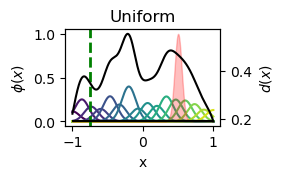

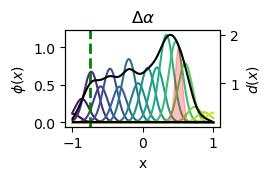

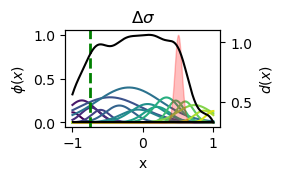

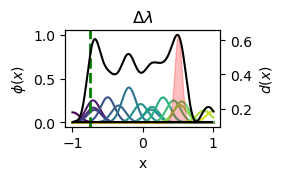

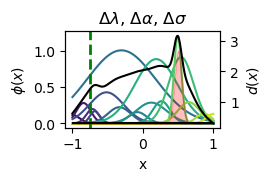

In [67]:
# plot example field 
ltypes = [0.0, 0.0001]
pcinit = 'rand'
names_dict = {'llr': r'$\Delta\lambda$', 'alr': r'$\Delta\alpha$', 'slr': r'$\Delta\sigma$'}
for llr in ltypes:
    for slr in ltypes:
        for alr in ltypes:

            try:
                [logparams, latencys,cum_rewards, allcoords] = saveload(f"./data/1D_td_online_0.0ba_0.0ns_01234p_16n_0.01plr_0.01clr_{llr}llr_{alr}alr_{slr}slr_{pcinit}_0.5a_0.1s_2a_2020s_50000e_5rmax_0.05rsz",1,"load")
                
                name_components = []
                if llr > 0:
                    name_components.append(names_dict['llr'])
                if alr > 0:
                    name_components.append(names_dict['alr'])
                if slr > 0:
                    name_components.append(names_dict['slr'])
                name = ', '.join(name_components) if name_components else 'Uniform'
                
                f,ax = plt.subplots(figsize=(2,1.25))
                plot_pc(logparams, trial=-1,ax=ax, goalsize=0.05)
                ax.set_ylabel('$\phi(x)$')
                ax.set_xlabel('x')
                ax.set_title(name)
                ax.legend().set_visible(False)

                ax2 = ax.twinx()
                plot_density(logparams, [50000], ax=ax2, goalsize=0.05)
                ax2.set_ylabel('$d(x)$')
                ax2.legend().set_visible(False)
                
                f.savefig(f'./fig/1D_{pcinit}_{name}.svg')

            except FileNotFoundError: print('skip')



In [56]:
# theory vs simulation
llr = 0.0001
slr = 0.0001
alr = 0.0001
total_trials = 50000
num = 100
[logparams, latencys,cum_rewards, allcoords] = saveload(f"./data/wv_1D_td_online_0.0ba_0.0ns_01234p_16n_0.01plr_0.01clr_{llr}llr_{alr}alr_{slr}slr_{pcinit}_0.5a_0.1s_2a_2020s_50000e_5rmax_0.05rsz",1,"load")


lambdas = []
sigmas = []
alphas = []
policys = []
values = []
episodes = np.arange(total_trials)
for e in episodes:
    lambdas.append(logparams[e][0])
    sigmas.append(logparams[e][1])
    alphas.append(logparams[e][2])
    policys.append(logparams[e][3])
    values.append(logparams[e][4])
lambdas = np.array(lambdas)
sigmas = np.array(sigmas)
alphas = np.array(alphas)
policys = np.array(policys)
values = np.array(values)

print(alphas.shape)
                

(50000, 16)


0.49999997683982234 0.5000044747882745
9.708261993376936e-18 0.0002304327766799069
0.4999998581464691 0.5003565045461323
2.878011101523187e-20 0.018017486271627838
0.4999999999995663 0.5240708082695023
3.56621449261022e-17 1.2335965432536917
0.49999999999933353 0.5546506170756141
1.0793437788211112e-17 2.882887818855927
0.49999999999898187 0.5563986313767683
1.9774138471408856e-10 2.979848046873679
0.49999999999969524 0.5535627577196099
1.0014596594663633e-10 2.822417795788354
0.499999999998912 0.5590210710209319
7.194284384961815e-16 3.1262495518991025
0.4999999999991944 0.5630281114401685
6.163038378948317e-14 3.3515968133574763
0.4999999999905313 0.5373137481024999
1.85512894760037e-11 1.937114664940466
0.5 0.5388341667397363
4.384441779827203e-12 2.03425738640008
0.5 0.7208472328065527
1.734205180754751e-10 13.56511082934818
0.5 0.7358862821168967
1.1154056825787269e-11 14.683413036380761
0.5 0.7063750295517437
5.97105142041278e-13 12.56869461427638
0.4999989808883467 0.58955992330

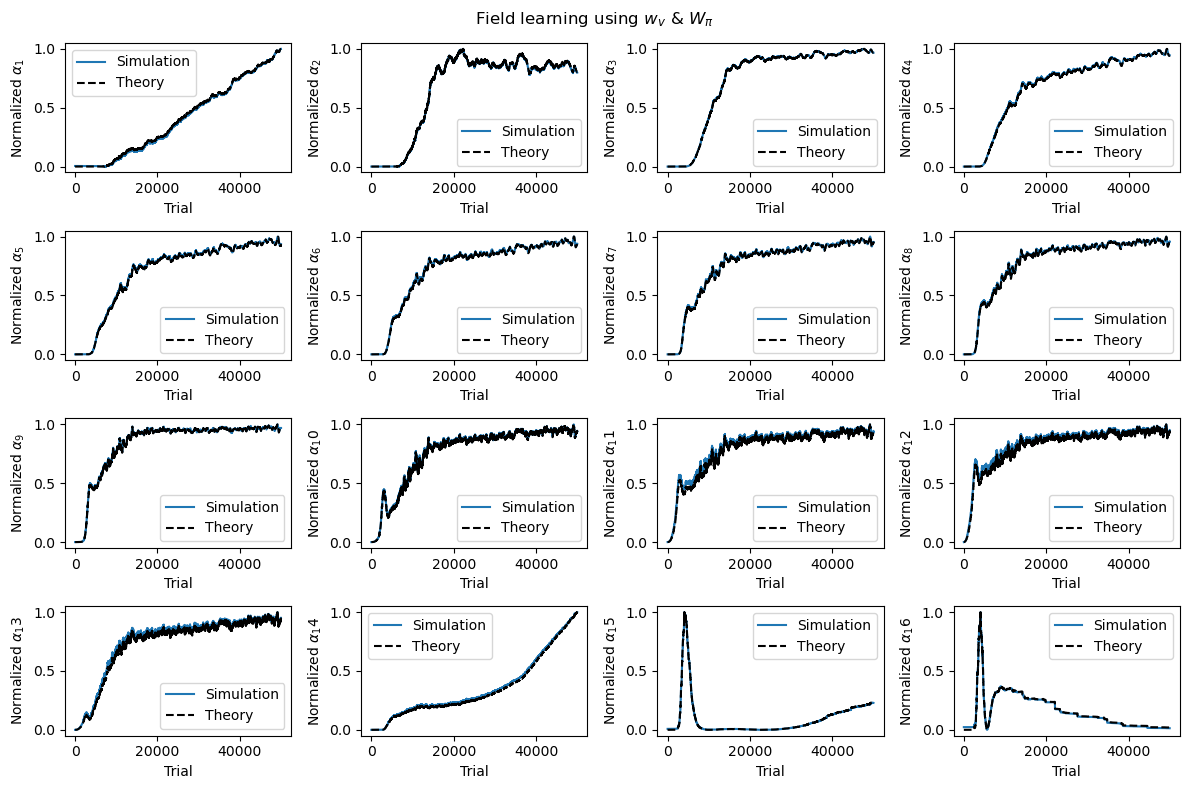

In [57]:
def normalize_values(x):
    maxval = np.max(x)
    minval = np.min(x)
    print(minval, maxval)
    return (x-minval)/(maxval-minval)

trial_max = 50000
f,ax = plt.subplots(4,4, figsize=(12,8))
f.suptitle('Field learning using $w_v$ & $W_{\pi}$')
ax = ax.flatten()
for n in np.arange(16):
    sim = normalize_values(alphas[:trial_max,n])
    theory = normalize_values(values[:trial_max,n,0]**2)
    ax[n].plot(np.arange(trial_max), sim)
    ax[n].plot(np.arange(trial_max), theory, linestyle='--',color='k')

    ax[n].plot([],[],label='Simulation',color='tab:blue')
    ax[n].plot([],[], linestyle='--',label='Theory',color='k')

    # diff = abs(sim-theory)
    # plt.plot(np.arange(trial_max), diff)
    i = n+1
    ax[n].set_ylabel(f'Normalized $\\alpha_{i}$')
    ax[n].set_xlabel('Trial')
    ax[n].legend()

f.tight_layout()
# ax = plt.twinx()
# ax.plot(np.arange(trial_max), moving_average(latencys,100)[:trial_max], color='tab:orange')
# ax.set_ylabel('Latency')


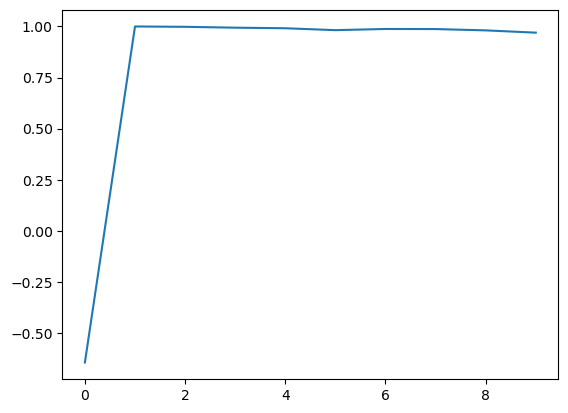

In [33]:
# correlation over time
trials = np.linspace(1,10000,num=10,dtype=int)
R = []
for trial in trials:
    rcorr = np.corrcoef(alphas[trial], values[trial,:,0]**2)[0,1]
    R.append(rcorr)
plt.plot(R)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


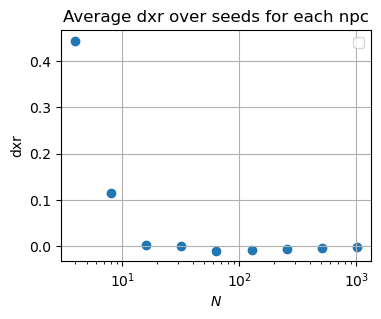

In [31]:

# Calculate the average dxr over all seeds for each npc
average_dxrs = np.mean(dxrs, axis=1)

# Plotting
# plt.figure(figsize=(4, 3))
# for idx, npc in enumerate(npcs):
#     plt.plot(np.linspace(0, train_episodes, trial_len), average_dxrs[idx], label=f'npc={npc}')

# plt.xlabel('Trials')
# plt.ylabel('Average dxr')
# plt.legend()
# plt.title('Average dxr over seeds for each npc')
# plt.grid(True)
# plt.show()


# Calculate the average dxr over all seeds for each npc
last_dxrs = average_dxrs[:,-1]

# Plotting
plt.figure(figsize=(4, 3))
plt.scatter(npcs, last_dxrs)

plt.xscale('log')
# plt.yscale('log')

plt.xlabel('$N$')
plt.ylabel('dxr')
plt.legend()
plt.title('Average dxr over seeds for each npc')
plt.grid(True)
plt.show()

In [36]:


# Load the CSV file with proper error handling
csv_file_path = './csvs/results_rmax.csv'
df = pd.read_csv(csv_file_path)

# Ensure all necessary columns are of the correct type
df['rmax'] = df['rmax'].astype(int)
df['seed'] = df['seed'].astype(int)
df['plr'] = df['plr'].astype(float)
df['clr'] = df['clr'].astype(float)

df['llr'] = df['llr'].astype(float)
df['alr'] = df['alr'].astype(float)
df['slr'] = df['slr'].astype(float)


# Parameters
train_episodes = 50000
rmaxs = [1,2,3,4,5,6,7,8,9,10]
seed_count = 10  # Specify the number of seeds to use

plrs = 0.01
clrs = 0.01
llrs = 0.0001
alrs = 0.0001
slrs = 0.0001

trial_len = 100  # Looks like you're trying to match this to the number of trials

# Initialize matrices to store scores and drifts
dxrs = np.zeros([len(rmaxs), seed_count, trial_len])

# Function to convert a string representation of array back to numpy array
def str_to_array(arr_str):
    # Ensure removal of newline characters and proper formatting of the string
    cleaned_str = arr_str.replace("\n", " ").replace('[ ', '[').replace(' ]', ']').replace('[', '').replace(']', '')
    # Ensure single spaces are replaced with a single comma
    cleaned_str = ','.join(cleaned_str.split())
    return np.array(ast.literal_eval(f"[{cleaned_str}]"))

# Fill the matrices with values from the CSV file
for i, row in df.iterrows():
    rmax = row['rmax']
    seed = row['seed']
    plr, clr, llr, alr, slr = row['plr'], row['clr'],row['llr'],row['alr'],row['slr']
    dxr_values = str_to_array(row['dxr'])

    if rmax in rmaxs and plr==plrs and clr==clrs and llr==llrs and alr==alrs and slr==slrs and seed < seed_count:
        rmax_idx = rmaxs.index(rmax)
        dxrs[rmax_idx, seed] = dxr_values

print(np.mean(dxrs[:,:,-1],axis=1))

[ 0.          0.          0.          0.          0.          0.
 -0.00462831 -0.00032186 -0.01018075  0.        ]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


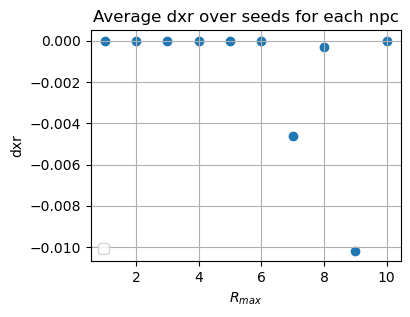

In [38]:

# Calculate the average dxr over all seeds for each npc
average_dxrs = np.mean(dxrs, axis=1)

# Calculate the average dxr over all seeds for each npc
last_dxrs = average_dxrs[:,-1]

# Plotting
plt.figure(figsize=(4, 3))
plt.scatter(rmaxs, last_dxrs)

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('$R_{max}$')
plt.ylabel('dxr')
plt.legend()
plt.title('Average dxr over seeds for each npc')
plt.grid(True)
plt.show()

In [27]:


# Load the CSV file with proper error handling
csv_file_path = './csvs/results_rsz.csv'
df = pd.read_csv(csv_file_path)

# Ensure all necessary columns are of the correct type
df['rsz'] = df['rsz'].astype(float)
df['seed'] = df['seed'].astype(int)

# Parameters
train_episodes = 50000
npcs = [0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25]
seed_count = 10  # Specify the number of seeds to use

trial_len = 100  # Looks like you're trying to match this to the number of trials

# Initialize matrices to store scores and drifts
dxrs = np.zeros([len(npcs), seed_count, trial_len])

# Function to convert a string representation of array back to numpy array
def str_to_array(arr_str):
    # Ensure removal of newline characters and proper formatting of the string
    cleaned_str = arr_str.replace("\n", " ").replace('[ ', '[').replace(' ]', ']').replace('[', '').replace(']', '')
    # Ensure single spaces are replaced with a single comma
    cleaned_str = ','.join(cleaned_str.split())
    return np.array(ast.literal_eval(f"[{cleaned_str}]"))

# Fill the matrices with values from the CSV file
for i, row in df.iterrows():
    npc = row['rsz']
    seed = row['seed']
    dxr_values = str_to_array(row['dxr'])

    if npc in npcs and seed < seed_count:
        npc_idx = npcs.index(npc)
        dxrs[npc_idx, seed] = dxr_values

print(dxrs[:,0,-1])

[ 0.01033836  0.01476889 -0.00073934 -0.01196285 -0.0205687  -0.03329506
  0.         -0.03259626 -0.03095501]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


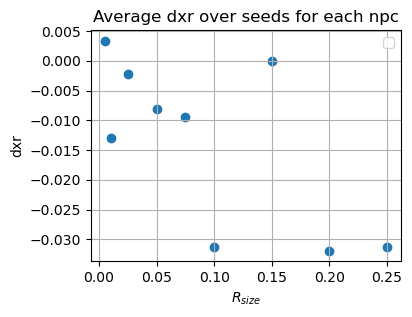

In [28]:

# Calculate the average dxr over all seeds for each npc
average_dxrs = np.mean(dxrs, axis=1)

# Calculate the average dxr over all seeds for each npc
last_dxrs = average_dxrs[:,-1]

# Plotting
plt.figure(figsize=(4, 3))
plt.scatter(npcs, last_dxrs)

# plt.xscale('log')
# plt.yscale('log')

plt.xlabel('$R_{size}$')
plt.ylabel('dxr')
plt.legend()
plt.title('Average dxr over seeds for each npc')
plt.grid(True)
plt.show()

In [4]:
import pandas as pd
import numpy as np
import ast

# Load the CSV file with proper error handling
csv_file_path = './csvs/results_sigma.csv'
df = pd.read_csv(csv_file_path)

# Ensure all necessary columns are of the correct type
df['npc'] = df['npc'].astype(int)
df['seed'] = df['seed'].astype(int)
df['plr'] = df['plr'].astype(float)
df['clr'] = df['clr'].astype(float)
df['llr'] = df['llr'].astype(float)
df['alr'] = df['alr'].astype(float)
df['slr'] = df['slr'].astype(float)
df['rsz'] = df['rsz'].astype(float)
df['sigma'] = df['sigma'].astype(float)

# Parameters
train_episodes = 50000
npcs = [4, 8, 16, 32, 64, 128]
rszs = [0.005, 0.01, 0.025, 0.05, 0.1, 0.15, 0.2]
sigmas = [0.005, 0.01, 0.025, 0.05, 0.1, 0.15, 0.2]
seed_count = 10  # Specify the number of seeds to use

plrs = 0.01
clrs = 0.01
llrs = 0.0001
alrs = 0.0001
slrs = 0.0001

trial_len = 100  # Looks like you're trying to match this to the number of trials

# Initialize matrices to store scores and drifts
dxrs = np.zeros([len(npcs), len(rszs), len(sigmas), seed_count, trial_len])

# Function to convert a string representation of array back to numpy array
def str_to_array(arr_str):
    if not isinstance(arr_str, str):
        # Handle non-string data, e.g., NaN or other non-string types
        return np.array([])  # or you could handle it differently
    # Ensure removal of newline characters and any extra characters
    cleaned_str = arr_str.replace("\n", " ").replace('[ ', '[').replace(' ]', ']').replace('...', '')
    return np.array(ast.literal_eval(cleaned_str))

# Fill the matrices with values from the CSV file
for i, row in df.iterrows():
    npc = row['npc']
    rsz = row['rsz']
    sigma = row['sigma']
    seed = row['seed']
    plr, clr, llr, alr, slr = row['plr'], row['clr'], row['llr'], row['alr'], row['slr']
    dxr_values = str_to_array(row['delta_dxr'])

    if npc in npcs and rsz in rszs and sigma in sigmas and plr == plrs and clr == clrs and llr == llrs and alr == alrs and slr == slrs and seed < seed_count:
        print(f'writing {npc},{rsz},{sigma}, {seed}')
        npc_idx = npcs.index(npc)
        sigma_idx = sigmas.index(sigma)
        rsz_idx = rszs.index(rsz)
        dxrs[npc_idx, rsz_idx, sigma_idx, seed] = dxr_values

# print(dxrs[0, 2, :, -1])

writing 4,0.1,0.01, 0
writing 4,0.1,0.025, 0
writing 4,0.15,0.025, 0
writing 4,0.15,0.005, 0
writing 4,0.15,0.01, 0
writing 4,0.05,0.025, 0
writing 4,0.05,0.01, 0
writing 4,0.15,0.05, 0
writing 4,0.1,0.05, 0
writing 4,0.1,0.005, 0
writing 4,0.05,0.05, 0
writing 4,0.025,0.05, 0
writing 4,0.2,0.15, 0
writing 4,0.15,0.15, 0
writing 4,0.05,0.1, 0
writing 4,0.15,0.1, 0
writing 4,0.1,0.15, 0
writing 4,0.1,0.1, 0
writing 4,0.025,0.025, 0
writing 4,0.05,0.15, 0
writing 4,0.05,0.005, 0
writing 4,0.2,0.2, 0
writing 4,0.15,0.2, 0
writing 4,0.2,0.1, 0
writing 4,0.025,0.1, 0
writing 4,0.1,0.2, 0
writing 4,0.025,0.15, 0
writing 4,0.05,0.2, 0
writing 4,0.025,0.2, 0
writing 8,0.025,0.005, 0
writing 8,0.15,0.005, 0
writing 4,0.01,0.1, 0
writing 8,0.1,0.005, 0
writing 8,0.2,0.005, 0
writing 4,0.01,0.15, 0
writing 4,0.01,0.05, 0
writing 8,0.05,0.005, 0
writing 4,0.01,0.2, 0
writing 8,0.15,0.01, 0
writing 8,0.2,0.01, 0
writing 8,0.1,0.01, 0
writing 8,0.05,0.01, 0
writing 8,0.15,0.05, 0
writing 8,0.1,0.05,

[ 1.  2.  5. 10. 20. 30. 40.]
[ 0.5  1.   2.5  5.  10.  15.  20. ]
[0.2 0.4 1.  2.  4.  6.  8. ]
[0.1 0.2 0.5 1.  2.  3.  4. ]
[0.05 0.1  0.25 0.5  1.   1.5  2.  ]
[0.03333333 0.06666667 0.16666667 0.33333333 0.66666667 1.
 1.33333333]
[0.025 0.05  0.125 0.25  0.5   0.75  1.   ]


Text(0.5, 1.0, 'Mean 10')

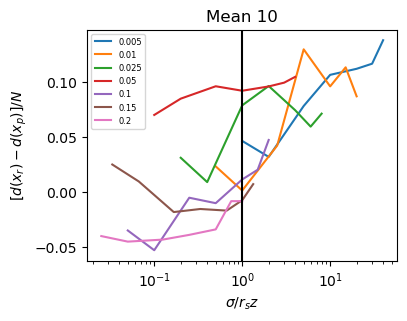

In [10]:
plt.figure(figsize=(4,3))
for r, rsz in enumerate(rszs):
    plt.plot(np.array(sigmas)/rsz, np.mean(dxrs[:, r,:,0,-1],axis=0), label=rsz)
    print(np.array(sigmas)/rsz)
    # idx=sigmas.index(rsz)
    # plt.scatter(sigmas[idx], np.mean(dxrs[:, r,:,0,-1],axis=0)[idx])
plt.axvline(1.0,color='k')
plt.xlabel(f'$\sigma/r_sz$')
plt.ylabel('$[d(x_r)-d(x_p)]/N$')
plt.legend(fontsize=6)
plt.xscale('log')
plt.title(f"Mean {seed_count}")

# for n,npc in enumerate(npcs):
#     plt.figure(figsize=(4,3))
#     for r, rsz in enumerate(rszs):
#         plt.plot(sigmas, dxrs[n, r,:,0,-1], label=rsz)

#     plt.xlabel('Sigma')
#     plt.ylabel('$[d(x_r)-d(x_p)]/N$')
#     plt.legend(fontsize=6)
#     plt.xscale('log')
#     plt.title(npc)

In [61]:
dxrs[2,0,0,:,-1]

array([ 0.05962034,  0.01963724,  0.02281274,  0.049506  , -0.05910595,
        0.06023858,  0.05284418,  0.05401538,  0.01777097,  0.1332685 ])

In [1]:
np.array(rsz)/np.array(sigmas)

NameError: name 'np' is not defined

In [7]:
np.array(rszs)/np.array(sigmas)

array([1., 1., 1., 1., 1., 1., 1.])

0.2557707214975658 0.06751922020217922 0.6763230900504463


(array([ 86., 200., 233., 222., 131.,  62.,  45.,  12.,   5.,   4.]),
 array([0.06751922, 0.12839961, 0.18927999, 0.25016038, 0.31104077,
        0.37192116, 0.43280154, 0.49368193, 0.55456232, 0.6154427 ,
        0.67632309]),
 <BarContainer object of 10 artists>)

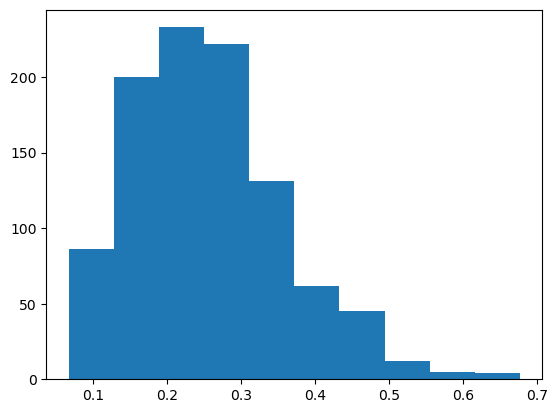

In [14]:
mean = 0.5
variance = 0.01
k = mean**2 / variance
theta = variance / mean

pc = np.random.gamma(k, theta, size=1000)**2
print(pc.mean(),pc.min(), pc.max())
plt.hist(pc)

In [8]:
np.sqrt(0.25)

0.5